In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC , NuSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet as wn
from operator import is_not
from functools import partial


import collections
import operator

import itertools

import csv

import random

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as dates


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [24]:
traindata = pd.read_csv("dataset/final_news.csv") #to read main data file

In [25]:

train_facebook_economy = pd.read_csv("dataset/Facebook_Economy.csv") #read facebook data of economy category

In [26]:

train_facebook_microsoft = pd.read_csv("dataset/Facebook_Microsoft.csv") #read facebook data of microsoft category

In [27]:

train_Facebook_Obama = pd.read_csv("dataset/Facebook_Obama.csv") #read facebook data of obama category

In [28]:

train_Facebook_Palestine = pd.read_csv("dataset/Facebook_Palestine.csv") #read facebook data of Palestine category

In [29]:
#concatinating all data of all 4 category
bigdata_facebook = pd.concat([train_facebook_economy, train_facebook_microsoft, train_Facebook_Obama, train_Facebook_Palestine], ignore_index=True)


In [30]:
facebook_merge = pd.merge(traindata, bigdata_facebook, on="IDLink") # merging main data and all facebook data
#print(len(traindata),len(bigdata_facebook))

In [31]:
#facebook_merge.Headline.isnull().sum() #dropping NAN or null values

In [32]:
# train_test_split to split data
X = facebook_merge.Headline
y = facebook_merge.Topic
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
#x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

In [33]:
#CLASSIFICATION using LinearSVC
vector = CountVectorizer(decode_error='replace', encoding='utf-8')
count = vector.fit_transform(x_train.values.astype(str))
tfidf = TfidfTransformer()
# x_traincv = cv1.fit_transform(x_train1.values.astype(str))
train_tfidf = tfidf.fit_transform(count)

In [34]:
txt_classifier = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), analyzer='char')),
                     ('tfidf', TfidfTransformer()),
                     ('dtc', LinearSVC()),])

In [35]:
y = txt_classifier.fit(x_train.values.astype(str), y_train.values.astype(str))
predicted = y.predict(x_test.values.astype(str))

In [36]:
f1_score(y_test, predicted, average='macro')

0.9517975170951242

In [37]:
#Testing one sentence to find similarity with other
focus_sentence = ["Microsoft reported steady growth in its latest round of financial results as the company's chief executive praised the performance of its cloud services."]      
value_category = y.predict(focus_sentence)

In [38]:
face_head = facebook_merge.Headline[facebook_merge.Topic==value_category[0]] # extracting headline of given category

In [39]:
face_head.isnull().sum() # to find number of null values
face_headline = face_head.dropna() # drop NAN value


In [40]:
names,cls = [],[]
for n in face_headline:
    names.append(n)

for n in facebook_merge.Topic:
    cls.append(n)
names = names[:10000]


In [41]:
# import nltk
# nltk.download('all')

In [42]:
def penn_to_wn(tag):
    """ Convert between a Penn Treebank tag to a simplified Wordnet tag """
    if tag.startswith('N'):
        return 'n'
 
    if tag.startswith('V'):
        return 'v'
 
    if tag.startswith('J'):
        return 'a'
 
    if tag.startswith('R'):
        return 'r'
 
    return None
 
def tagged_to_synset(word, tag):
    wn_tag = penn_to_wn(tag)
    if wn_tag is None:
        return None
 
    try:
        return wn.synsets(word, wn_tag)[0]
    except:
        return None

    
#finding similarity between different sentences based on synsets
def sentence_similarity(sentence1, sentence2):
    """ compute the sentence similarity using Wordnet """
    # Tokenize and tag
    sentence3 = []
    sentence2 = sentence2.split(' ')
    for i in range(len(sentence2)):
        if sentence2[i].isalpha():
            sentence3.append(sentence2[i])
    str1 = ""
    for i in sentence3:
        str1 += i + ','
    sentence1 = pos_tag(word_tokenize(sentence1))
    str1 = pos_tag(word_tokenize(str1))
    synsets1 = [tagged_to_synset(*tagged_word) for tagged_word in sentence1]
    synsets2 = [tagged_to_synset(*tagged_word) for tagged_word in str1]
    synsets1 = [ss for ss in synsets1 if ss]
    synsets2 = [ss for ss in synsets2 if ss]

    score, count = 0.0, 0
 
    for synset in synsets1:
        # Get the similarity value of the most similar word in the other sentence
            simlist = [synset.path_similarity(ss) for ss in synsets2 if synset.path_similarity(ss) is not None]
            if not simlist:
                continue;
            best_score = max(simlist)
        # Check that the similarity could have been computed
            score += best_score
            count += 1
    if count!=0:
        score /= count
    return score

In [43]:
i = 0
focus_sentence1 ="Microsoft reported steady growth in its latest round of financial results as the company's chief executive praised the performance of its cloud services."
a,sorted_list = {},[]
for sentence in names:
#     print(sentence,  i)
    i = i+1
    a[sentence] = sentence_similarity(focus_sentence1, sentence)
# print(a)
list8 = []
d = collections.Counter(a)
f = d.most_common(5)
res_list = [x[0] for x in f]
sorted_list = sorted(a.items(), key=operator.itemgetter(1), reverse = True)

In [44]:
sorted_list1 = [i[0] for i in sorted_list]

In [45]:
list3 = sorted_list1[:5]
print(len(list3))

5


In [46]:
#for sentiments
list_tsp_final_s,list_final_s = [],[]
for i in range(len(list3)):
    list_tsp_s = []
    a = facebook_merge[facebook_merge.Headline == list3[i]]
#     print(a)
    b_s = a.values.T.tolist()
    list_tsp_s.append(b_s[7])
    list_tsp_final_s.append(list_tsp_s)
print(list_tsp_final_s)
list3_one_s = list_tsp_final_s[0][0]
list3_two_s = list_tsp_final_s[1][0]
list3_three_s = list_tsp_final_s[2][0]
list3_four_s = list_tsp_final_s[3][0]
list3_five_s = list_tsp_final_s[4][0]
list_final_s.append((list3_one_s[0]+list3_two_s[0] + list3_three_s[0] + list3_four_s[0] + list3_five_s[0])/5)
list_final_s

[[[-0.016658355, -0.016658355]], [[-0.016363493]], [[-0.004964749]], [[0.03150948]], [[-0.18630575600000002]]]


[-0.038556574600000004]

In [47]:
# extracting values of timestamp from all the nearest sentences
list_tsp_final,list_final = [],[]
for i in range(len(list3)):
    list_tsp = []
    a = facebook_merge[facebook_merge.Headline == list3[i]]
#     print(a)
    b = a.values.T.tolist()
    list_tsp.append(b[8:])
    list_tsp_final.append(list_tsp)
list3_one = list_tsp_final[0][0]
list3_two = list_tsp_final[1][0]
list3_three = list_tsp_final[2][0]
list3_four = list_tsp_final[3][0]
list3_five = list_tsp_final[4][0]
list4_one =  list(itertools.chain.from_iterable(list3_one))
list4_two =  list(itertools.chain.from_iterable(list3_two))
list4_three =  list(itertools.chain.from_iterable(list3_three))
list4_four = list(itertools.chain.from_iterable(list3_four))
list4_five = list(itertools.chain.from_iterable(list3_five))
for i in range(len(list3_one)):
    list_final.append((list4_one[i]+list4_two[i] + list4_three[i] + list4_four[i] + list4_five[i])/5)

In [48]:
file_mname = pd.DataFrame(list_final)
file_mname.to_csv("time_file_final.csv") #saving timestamp values in csv format

In [49]:
traindata = pd.read_csv("time_file_final.csv")

In [50]:
rng = pd.date_range('1/1/2011', periods=144, freq='D') # taking range of date as a scale. Each day represents 20 minutes

In [51]:
series_date = pd.DatetimeIndex.to_series(rng)
type(series_date)
series_date.to_csv('date_time.csv', index = False)

In [52]:
df = pd.read_csv('date_time.csv', header=None)
list_date = list(df[0])
list_train = list(traindata['0'])

In [53]:
d_merge = {'Time':list_date,'popularity':list_train}

In [54]:
df = pd.DataFrame(d_merge)
df.shape
time = list(df['Time'])
df.set_index('Time', inplace = True)

In [55]:
df.to_csv("popularity_date2.csv")

In [56]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('popularity_date2.csv',date_parser=dateparse)
data.set_index('Time', inplace = True)


In [57]:
ts = data['popularity']
ts

Time
2011-01-01   -1.0
2011-01-02   -1.0
2011-01-03   -1.0
2011-01-04   -1.0
2011-01-05   -1.0
2011-01-06   -1.0
2011-01-07   -1.0
2011-01-08   -1.0
2011-01-09   -1.0
2011-01-10   -1.0
2011-01-11   -1.0
2011-01-12   -1.0
2011-01-13   -1.0
2011-01-14   -1.0
2011-01-15   -1.0
2011-01-16   -1.0
2011-01-17   -1.0
2011-01-18   -1.0
2011-01-19   -1.0
2011-01-20   -1.0
2011-01-21   -1.0
2011-01-22   -1.0
2011-01-23   -1.0
2011-01-24   -1.0
2011-01-25   -0.8
2011-01-26   -0.8
2011-01-27   -0.6
2011-01-28   -0.6
2011-01-29   -0.6
2011-01-30   -0.6
             ... 
2011-04-25    2.6
2011-04-26    1.4
2011-04-27    2.6
2011-04-28    1.4
2011-04-29    2.6
2011-04-30    1.4
2011-05-01    2.6
2011-05-02    1.4
2011-05-03    2.6
2011-05-04    1.4
2011-05-05    2.6
2011-05-06    1.4
2011-05-07    2.6
2011-05-08    1.4
2011-05-09    2.6
2011-05-10    1.4
2011-05-11    2.6
2011-05-12    1.4
2011-05-13    2.6
2011-05-14    1.4
2011-05-15    2.6
2011-05-16    1.4
2011-05-17    2.6
2011-05-18    1.4
2011-

In [58]:
t_data =  pd.Index.to_datetime(ts.index)
rcParams['figure.figsize'] = 12, 20

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  """Entry point for launching an IPython kernel.


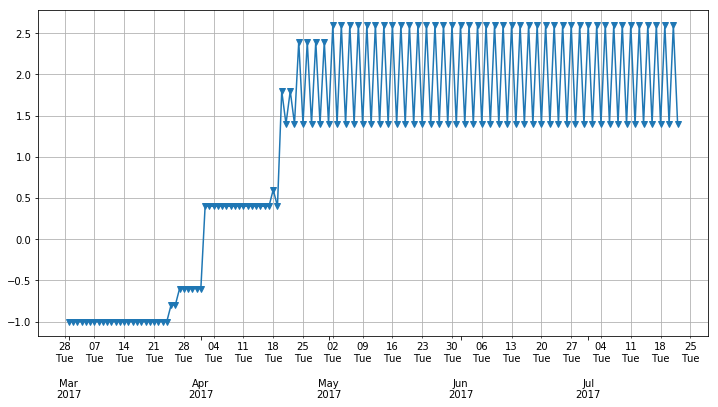

In [59]:
idx = pd.date_range('2017-03-01', '2017-07-22')
# s = pd.Series(np.random.randn(len(idx)), index=idx)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx, ts, 'v-')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

In [60]:
def test_stationarity(idx,timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    orig = ax.plot_date(idx, timeseries ,'v-', color='blue',label='Original')
    mean = ax.plot_date(idx, rolmean,'v-', color='red', label='Rolling Mean')
    std = ax.plot_date(idx, rolstd , 'v-',color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
    ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
    ax.xaxis.grid(True, which="minor")
    ax.yaxis.grid()
    ax.xaxis.set_major_locator(dates.MonthLocator())
    ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
    # plt.tight_layout()
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

144


/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


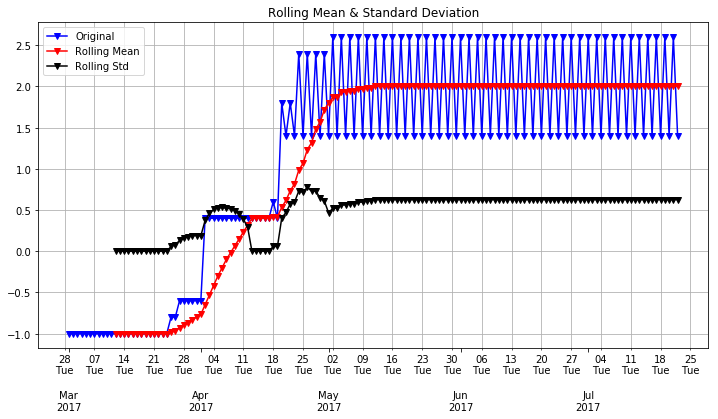

Results of Dickey-Fuller Test:
Test Statistic                  -1.823071
p-value                          0.369069
#Lags Used                       5.000000
Number of Observations Used    138.000000
Critical Value (1%)             -3.478648
Critical Value (5%)             -2.882722
Critical Value (10%)            -2.578065
dtype: float64


In [61]:
print(len(ts))
idx2 = pd.date_range('2017-03-01', periods=len(ts), freq='D')
test_stationarity(idx2,ts)

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


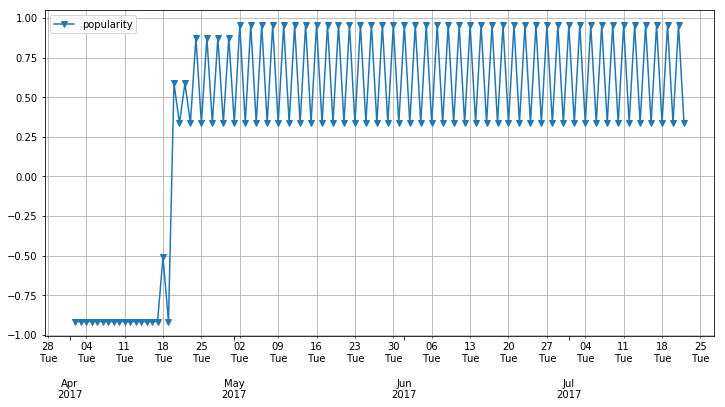

In [62]:
ts_log = np.log(ts)
fig, ax = plt.subplots(figsize=(12, 6))
idx2 = pd.date_range('2017-03-01', periods=len(ts_log), freq='D')
ax.plot_date(idx2, ts_log , 'v-')
plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  import sys


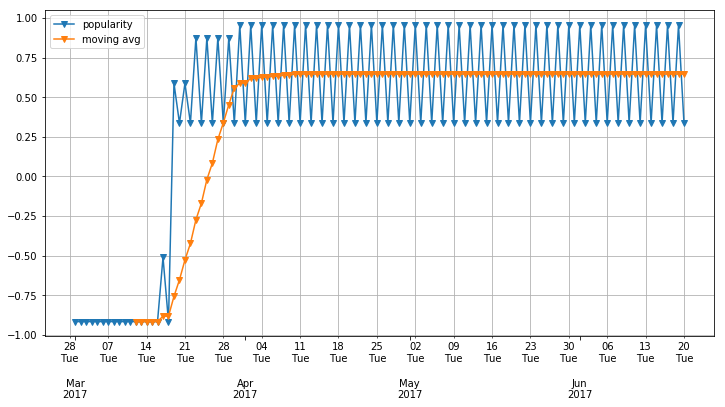

In [63]:
# idx = pd.date_range('2017-03-01', periods=len(ts_len), freq='D')
# idx = pd.date_range('2017-03-01', '2017-07-24')
idx1 = pd.date_range('2017-03-01', '2017-07-24')
ts_log = ts_log.dropna()
ts_len = len(ts_log)
idx1 = pd.date_range('2017-03-01', periods=ts_len, freq='D')
moving_avg = pd.rolling_mean(ts_log,12)
ts_mov = len(moving_avg)
# print(ts_len)
# print(ts_mov)
idx = pd.date_range('2017-03-01', periods=ts_mov, freq='D')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx1, ts_log , 'v-')
ax.plot_date(idx, moving_avg , 'v-', label = 'moving avg')
plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


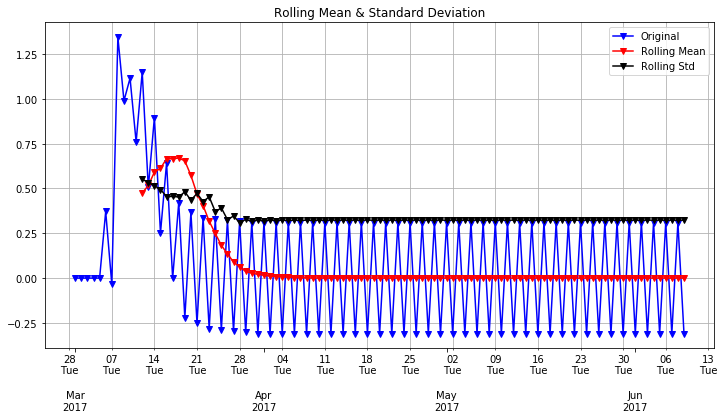

Results of Dickey-Fuller Test:
Test Statistic                -1.146562e+01
p-value                        5.420216e-21
#Lags Used                     1.300000e+01
Number of Observations Used    8.700000e+01
Critical Value (1%)           -3.507853e+00
Critical Value (5%)           -2.895382e+00
Critical Value (10%)          -2.584824e+00
dtype: float64


In [64]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)
ts_log_moving_avg_diff.dropna(inplace=True)
#print(len(ts_log_moving_avg_diff))
idx3 = pd.date_range('2017-03-01', periods=len(ts_log_moving_avg_diff), freq='D')
test_stationarity(idx3,ts_log_moving_avg_diff)

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(halflife=12,min_periods=0,adjust=True,ignore_na=False).mean()
  """Entry point for launching an IPython kernel.
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


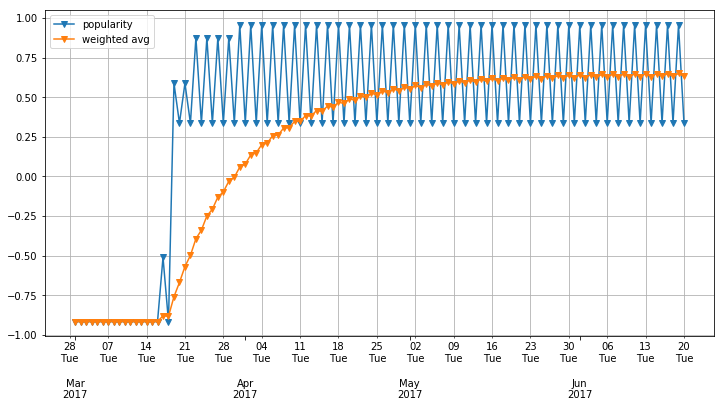

In [65]:
expwighted_avg = pd.ewma(ts_log, halflife=12)
ts_log = ts_log.dropna()
moving_avg = pd.rolling_mean(ts_log,12)
idx4 = pd.date_range('2017-03-01', periods=len(ts_log), freq='D')
idx5 = pd.date_range('2017-03-01', periods=len(moving_avg), freq='D')
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx4, ts_log , 'v-')
ax.plot_date(idx5, expwighted_avg , 'v-', label = 'weighted avg')
plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


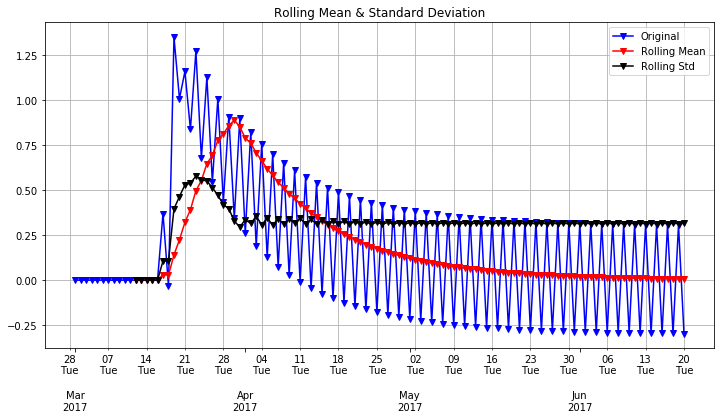

Results of Dickey-Fuller Test:
Test Statistic                  -1.994149
p-value                          0.289144
#Lags Used                       5.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [66]:
ts_log_ewma_diff = ts_log - expwighted_avg
ts_log_ewma_diff = ts_log_ewma_diff.dropna()
#print(len(ts_log_ewma_diff))
idx6 = pd.date_range('2017-03-01', periods=len(ts_log_ewma_diff), freq='D')
test_stationarity(idx6,ts_log_ewma_diff)

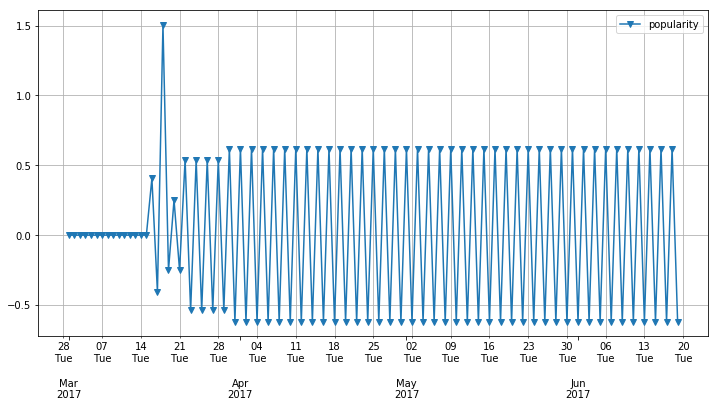

In [67]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff = ts_log_diff.dropna()

fig, ax = plt.subplots(figsize=(12, 6))
idx7 = pd.date_range('2017-03-01', periods=len(ts_log_diff), freq='D')

ax.plot_date(idx7, ts_log_diff , 'v-')
# ax.plot_date(idx, expwighted_avg , 'v-', label = 'weighted avg')
plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


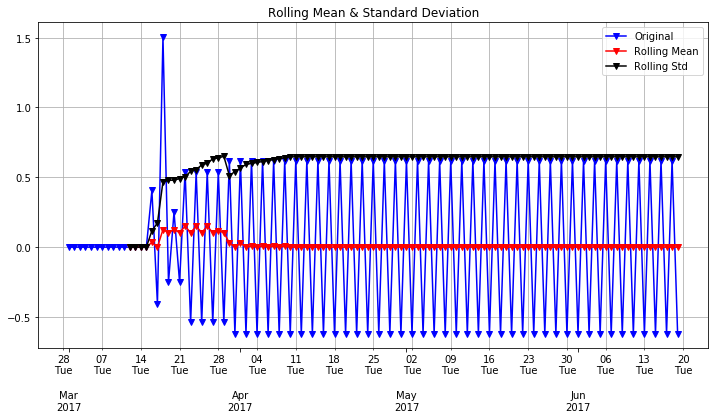

Results of Dickey-Fuller Test:
Test Statistic                  -4.306437
p-value                          0.000433
#Lags Used                       4.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [68]:
ts_log_diff.dropna(inplace=True)
idx8 = pd.date_range('2017-03-01', periods=len(ts_log_diff), freq='D')
test_stationarity(idx8,ts_log_diff)

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


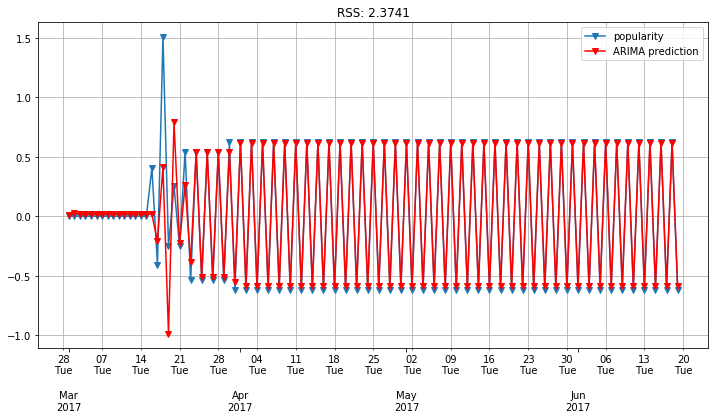

In [69]:
#print(ts_log)
ts_log = ts_log.dropna()
idx = pd.date_range('2017-03-01', '2017-07-23')

model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1) 
# results_AR.isnull().sum()
idx10 = pd.date_range('2017-03-01', periods=len(ts_log_diff), freq='D')

idx11 = pd.date_range('2017-03-01', periods=len(results_AR.fittedvalues), freq='D')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx10, ts_log_diff , 'v-')
ax.plot_date(idx11, results_AR.fittedvalues, 'v-', label = 'ARIMA prediction', color='red' )

# ax.plot_date(idx, expwighted_avg , 'v-', label = 'weighted avg')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood o

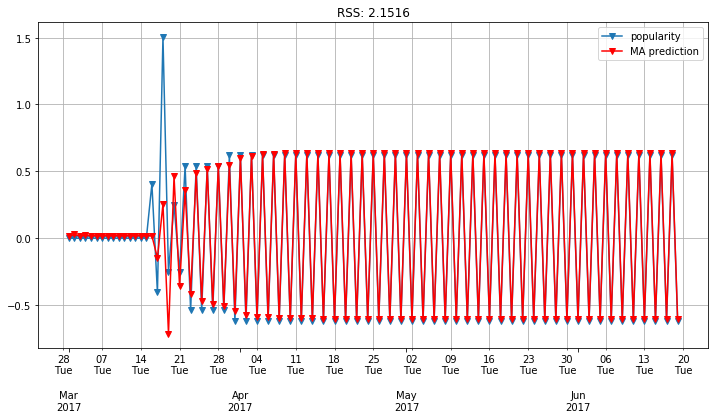

In [70]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_MA = model.fit(disp=-1)  

fig, ax = plt.subplots(figsize=(12, 6))
idx12 = pd.date_range('2017-03-01', periods=len(ts_log_diff), freq='D')
idx13 = pd.date_range('2017-03-01', periods=len(results_MA.fittedvalues), freq='D')

ax.plot_date(idx12, ts_log_diff , 'v-')
ax.plot_date(idx13, results_MA.fittedvalues, 'v-', label = 'MA prediction', color='red' )

# ax.plot_date(idx, expwighted_avg , 'v-', label = 'weighted avg')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

In [71]:
predictions_ARIMA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Time
2011-02-03    0.014135
2011-02-04    0.028271
2011-02-05    0.016786
2011-02-06    0.020967
2011-02-07    0.017408
dtype: float64


In [72]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Time
2011-02-03    0.014135
2011-02-04    0.042406
2011-02-05    0.059192
2011-02-06    0.080159
2011-02-07    0.097566
dtype: float64


In [73]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Time
2011-02-02   -0.916291
2011-02-03   -0.902155
2011-02-04   -0.873885
2011-02-05   -0.857099
2011-02-06   -0.836132
dtype: float64

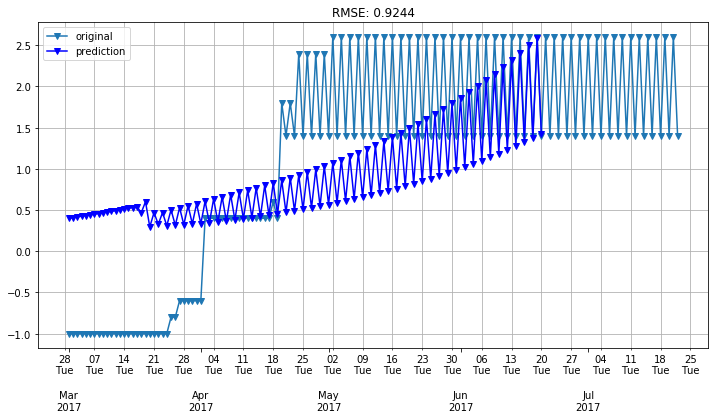

In [74]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
fig, ax = plt.subplots(figsize=(12, 6))
idx14 = pd.date_range('2017-03-01', periods=len(ts), freq='D')
idx15 = pd.date_range('2017-03-01', periods=len(predictions_ARIMA), freq='D')
ax.plot_date(idx14, ts ,'v-' ,label = "original")
ax.plot_date(idx15, predictions_ARIMA, 'v-', label = 'prediction', color='blue' )
# ax.plot_date(idx, expwighted_avg , 'v-', label = 'weighted avg')
value = (predictions_ARIMA-ts)**2
value = value.dropna()
plt.title('RMSE: %.4f'% np.sqrt(sum(value)/len(ts)))

plt.legend(loc='best')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),                                           interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

In [75]:
# USING LSTM TIME-SERIES
import pandas as pd
import random
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.dates as mdates
import seaborn as sns
import numpy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
get_ipython().magic('matplotlib inline')
ts = data['popularity']


/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


/Users/abhishekyadav/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  """Entry point for launching an IPython kernel.


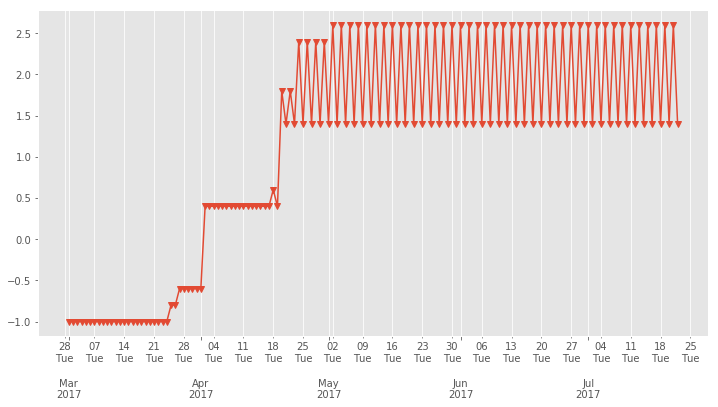

In [76]:
t_data =  pd.Index.to_datetime(ts.index)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
idx20 = pd.date_range('2017-03-01', periods=len(ts), freq='D')

# s = pd.Series(np.random.randn(len(idx)), index=idx)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx20, ts, 'v-')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

In [77]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


In [78]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [79]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [80]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [81]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model


In [82]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0,0]


In [83]:
series = pd.Series(ts)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [84]:
repeats = 30
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)



1) Test RMSE: 1.081
2) Test RMSE: 1.115
3) Test RMSE: 1.098
4) Test RMSE: 1.056
5) Test RMSE: 1.061
6) Test RMSE: 1.042
7) Test RMSE: 0.866
8) Test RMSE: 1.196
9) Test RMSE: 1.052
10) Test RMSE: 1.097
11) Test RMSE: 0.982
12) Test RMSE: 1.026
13) Test RMSE: 0.974
14) Test RMSE: 0.979
15) Test RMSE: 1.039
16) Test RMSE: 1.000
17) Test RMSE: 1.130
18) Test RMSE: 1.119
19) Test RMSE: 1.041
20) Test RMSE: 0.856
21) Test RMSE: 1.067
22) Test RMSE: 1.033
23) Test RMSE: 1.121
24) Test RMSE: 0.941
25) Test RMSE: 1.084
26) Test RMSE: 0.980
27) Test RMSE: 1.020
28) Test RMSE: 1.130
29) Test RMSE: 1.018
30) Test RMSE: 0.916


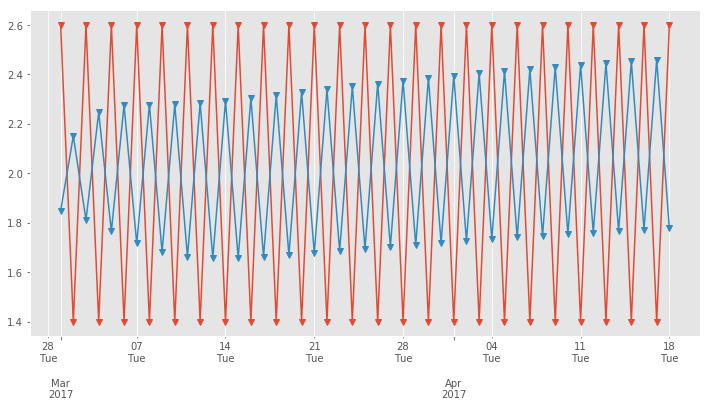

In [96]:
idx16 = pd.date_range('2017-03-01', periods=len(raw_values[train_size:len(supervised_values)]), freq='D')
idx17 = pd.date_range('2017-03-01', periods=len(predictions), freq='D')

# s = pd.Series(np.random.randn(len(idx)), index=idx)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx16, raw_values[train_size:len(supervised_values)], 'v-')
ax.plot_date(idx17, predictions, 'v-', label = 'predicted')

ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                                interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()

In [86]:
results = pd.DataFrame()
results['rmse'] = error_scores

In [87]:
f = np.array(16.7)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)
train_scaled

array([[-1.]])

In [88]:
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])


In [89]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)

In [90]:
rng = pd.date_range('2017-08-25', periods=40, freq='D')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Time', 'popularity']


In [91]:
original = pd.DataFrame({'Time':ts.index, 'popularity':ts.values})

In [92]:
frames = [original, prediction]
df_final = pd.concat(frames)

In [93]:
df_final.set_index(df_final.Time,inplace=True)

In [94]:
df_final = pd.Series(df_final.popularity)

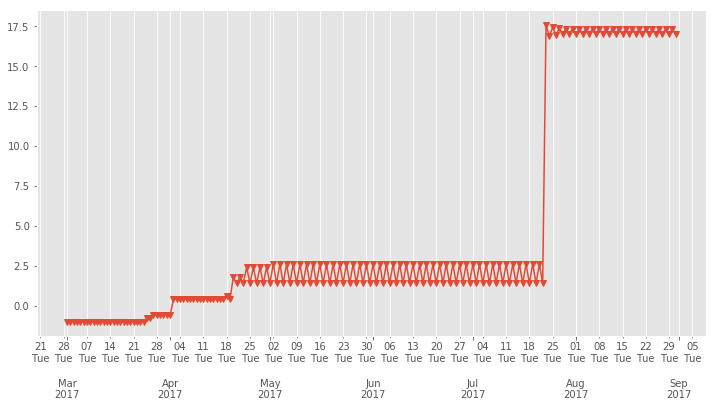

In [95]:
idx18 = pd.date_range('2017-03-01', periods=len(df_final), freq='D')

s = pd.Series(np.random.randn(len(idx)), index=idx)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot_date(idx18, df_final, 'v-')
ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(1),
                                             interval=1))
ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n%a'))
ax.xaxis.grid(True, which="minor")
ax.yaxis.grid()
ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_major_formatter(dates.DateFormatter('\n\n\n%b\n%Y'))
# plt.tight_layout()
plt.show()